Optimal Control Sequence:
[[-1.          1.        ]
 [-0.98259584  1.        ]
 [ 0.65807218  1.        ]
 [ 0.73296979  1.        ]
 [ 0.59155386  1.        ]
 [-0.03219445 -0.00948046]]
Resulting Trajectory:
[[ 0.00000000e+00  0.00000000e+00]
 [-1.00000000e+00  1.00000000e+00]
 [-1.98259584e+00  2.00000000e+00]
 [-1.32452366e+00  3.00000000e+00]
 [-5.91553872e-01  4.00000000e+00]
 [-7.93751875e-09  5.00000000e+00]
 [-3.21944592e-02  4.99051954e+00]]


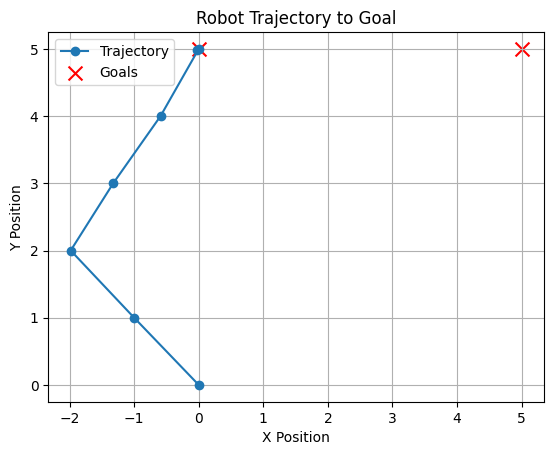

In [65]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define system dynamics
def system_dynamics(x, u, dt=1):
    return x + u * dt

# Define observation model
def observation_model(x):
    return x

# Define free energy functional
def free_energy(x, goal):
    prediction_error = np.linalg.norm(observation_model(x) - goal)
    return prediction_error

def compute_distance(x,goals):
    return np.linalg.norm(x-goals,axis=1)

def compute_evidence(x,goals,eta=10):
    evidence = compute_distance(x,goals)
    return eta * np.exp(-1.0 / eta * evidence)

def compute_entropy(evidence):
    likelihood = np.exp(-evidence) / np.sum(np.exp(-evidence))
    total_cost = -np.dot(likelihood.T,np.log(likelihood))
    return total_cost

def compute_cost(x,goals):
    evidence = compute_evidence(x,goals)
    return compute_entropy(evidence)*1e3

# Define the optimization objective function
def objective(u, x, goal, N, dt=1, lambda_reg=0.01):
    total_free_energy = 0
    x_curr = x.copy()
    u = u.reshape(N, 2)
    for k in range(N):
        u_curr = u[k]
        x_next = system_dynamics(x_curr, u_curr, dt)
        total_free_energy += compute_cost(x_next, goals) + lambda_reg * np.sum(u_curr ** 2)
        x_curr = x_next
    return total_free_energy

# Simulation parameters
N = 6 # Horizon length
dt = 1  # Time step
lambda_reg = 0.01  # Regularization parameter
goals = np.array([[5.0, 5.0], [0,5.0]])  # Goal position
x_init = np.array([0.0, 0.0])  # Initial position
u_init = np.random.rand(N,2) # Initial control sequence (velocities)

# Define constraints for control inputs
u_bounds = [(-1, 1), (-1, 1)] * N

# Optimize the control sequence
result = minimize(objective, u_init.flatten(), args=(x_init, goals, N, dt, lambda_reg), bounds=u_bounds, method='L-BFGS-B')

# Extract the optimal control sequence
optimal_u = result.x.reshape(N, 2)

# Simulate the system with the optimal control sequence
x = x_init.copy()
trajectory = [x]
for u in optimal_u:
    x = system_dynamics(x, u, dt)
    trajectory.append(x)

trajectory = np.array(trajectory)

# Print the resulting trajectory
print("Optimal Control Sequence:")
print(optimal_u)
print("Resulting Trajectory:")
print(trajectory)

# Plotting the trajectory
plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', label='Trajectory')
plt.scatter(goals[:,0], goals[:,1], marker='x', color='red', label='Goals', s=100)
plt.title('Robot Trajectory to Goal')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid()
plt.show()


Optimal Control Sequence (Agent 1):
[[ 1.00000000e+00 -8.36447581e-01]
 [ 1.00000000e+00  9.99999969e-01]
 [ 2.87308244e-01  3.27874291e-01]
 [-1.55490335e-03  1.20624052e-03]
 [-6.98699610e-04  2.11189336e-05]
 [ 2.14938503e-05 -7.08555137e-05]]
Optimal Control Sequence (Agent 2):
[[ 6.02636288e-01  9.99994964e-01]
 [-1.69308812e-01  1.77542134e-01]
 [ 2.62750966e-03 -1.00662880e-03]
 [-2.46899203e-03  8.95826989e-04]
 [ 6.49576334e-02 -3.20259539e-02]
 [-6.51289034e-02  3.21198054e-02]]
Resulting Trajectories:
[[[1.23246207 1.20827227]
  [3.08421036 0.52337621]]

 [[2.23246207 0.37182469]
  [3.68684665 1.52337118]]

 [[3.23246207 1.37182465]
  [3.51753784 1.70091331]]

 [[3.51977031 1.69969895]
  [3.52016535 1.69990668]]

 [[3.51821541 1.70090519]
  [3.51769635 1.70080251]]

 [[3.51751671 1.70092631]
  [3.58265399 1.66877656]]

 [[3.5175382  1.70085545]
  [3.51752508 1.70089636]]]


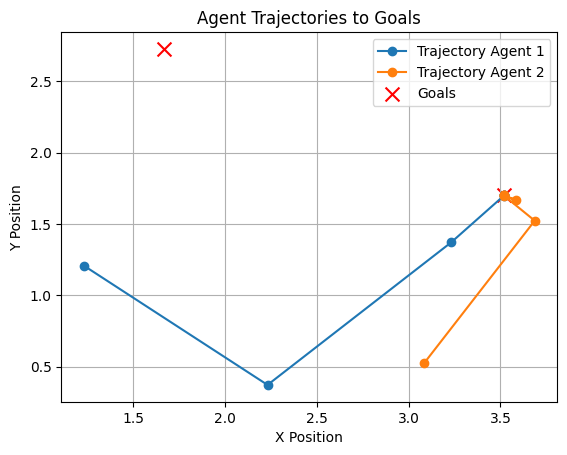

In [119]:
# First order reasoning
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define system dynamics
def system_dynamics(x, u, dt=1):
    return x + u * dt

# Define observation model
def observation_model(x):
    return x

# Define free energy functional
def free_energy(x, goal):
    prediction_error = np.linalg.norm(observation_model(x) - goal)
    return prediction_error

def compute_distance(x,goals):
    # Compute the pairwise differences
    diff = x[:, np.newaxis, :] - goals[np.newaxis, :, :]
    
    # Compute the pairwise distances
    distances = np.linalg.norm(diff, axis=2)
    return distances

def compute_evidence(x,goals,eta=10):
    evidence = compute_distance(x,goals)
    return eta * np.exp(-1.0 / eta * evidence)

def compute_entropy(evidence):
    sum_evidence = np.sum(evidence, axis=0)
    likelihood = np.exp(-sum_evidence) / np.sum(np.exp(-sum_evidence))
    total_cost = -np.dot(likelihood.T,np.log(likelihood))
    return total_cost

def compute_cost(x,goals):
    evidence = compute_evidence(x,goals)
    return compute_entropy(evidence)*1e1

# Define the optimization objective function for two agents
def objective(u, x_init, goals, N, dt=1, lambda_reg=0.01):
    total_free_energy = 0
    u = u.reshape(2, N, 2)  # Reshape for two agents
    x_curr = x_init.copy()
    
    for k in range(N):
        u_curr = u[:, k]
        
        # Update positions for both agents
        x_next = system_dynamics(x_curr, u_curr, dt)
        
        # Calculate total free energy considering the evidence for each other
        total_free_energy += compute_cost(x_next, goals)  # Agent 1 considering Agent 2's goal
        total_free_energy += lambda_reg * (np.sum(u_curr ** 2))  # Regularization
        
        # Update current positions
        x_curr = x_next
    
    return total_free_energy

# Simulation parameters
env_size = 6  # Environment size
N = int(env_size)  # Horizon length
dt = 1  # Time step
lambda_reg = 0.01  # Regularization parameter
num_goals = 2  # Number of goals
num_agents = 2  # Number of agents
goals = np.random.rand(num_goals,2)*env_size  # Goal positions for both agents
# goals = np.array([[5.0, 5.0], [0,5.0]])  # Goal position
x_init = np.random.rand(num_agents,2)*env_size  # Initial positions for both agents
# x_init = np.array([[0.0, 0.0], [1.0, 0.0]])  # Initial position
u_init = np.random.rand(2, N, 2)  # Initial control sequences for both agents (velocities)

# Define constraints for control inputs
u_bounds = [(-1, 1), (-1, 1)] * N * 2

# Optimize the control sequence
result = minimize(objective, u_init.flatten(), args=(x_init, goals, N, dt, lambda_reg), bounds=u_bounds, method='L-BFGS-B')

# Extract the optimal control sequence
optimal_u = result.x.reshape(2, N, 2)

# Simulate the system with the optimal control sequence
x = x_init.copy()
trajectories = [x.copy()]
for k in range(N):
    u_agent1 = optimal_u[0, k]
    u_agent2 = optimal_u[1, k]
    x[0] = system_dynamics(x[0], u_agent1, dt)
    x[1] = system_dynamics(x[1], u_agent2, dt)
    trajectories.append(x.copy())

trajectories = np.array(trajectories)

# Print the resulting trajectories
print("Optimal Control Sequence (Agent 1):")
print(optimal_u[0])
print("Optimal Control Sequence (Agent 2):")
print(optimal_u[1])
print("Resulting Trajectories:")
print(trajectories)

# Plotting the trajectories
plt.plot(trajectories[:, 0, 0], trajectories[:, 0, 1], marker='o', label='Trajectory Agent 1')
plt.plot(trajectories[:, 1, 0], trajectories[:, 1, 1], marker='o', label='Trajectory Agent 2')
plt.scatter(goals[:,0], goals[:,1], marker='x', color='red', label='Goals', s=100)
plt.title('Agent Trajectories to Goals')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid()
plt.show()


Optimization time: 2.491006851196289
Optimal Control Sequence (Agent 1):
[[ 7.51279078e-02  1.00000000e+00]
 [ 4.13844840e-01  1.00000000e+00]
 [ 1.58513062e-01  4.93928564e-01]
 [ 2.76740685e-02  1.26271369e-01]
 [ 5.67839825e-04 -1.70351548e-04]]
Optimal Control Sequence (Agent 2):
[[ 1.00000000e+00  4.14612246e-01]
 [ 8.64688382e-01 -3.06071966e-01]
 [ 3.13240302e-01 -1.67141292e-01]
 [-1.71763429e-04  2.29292097e-05]
 [ 2.04676550e-04 -6.50374426e-05]]
Optimal Control Sequence (Agent 3):
[[0.54495751 1.        ]
 [0.82778167 1.        ]
 [0.59974453 0.81584729]
 [0.28234318 0.3726995 ]
 [0.0678741  0.11377269]]
Optimal Control Sequence (Agent 4):
[[-2.59359957e-01 -1.00000000e+00]
 [ 8.15022072e-04 -2.29438133e-02]
 [-8.63676410e-05 -3.74883926e-05]
 [ 6.08514218e-05  4.86733259e-05]
 [ 5.13309821e-05 -1.29234724e-05]]
Resulting Trajectories:
[[[2.49253506 1.12398323]
  [0.99031432 3.80265356]
  [0.84555418 0.44169907]
  [3.42679909 4.76696673]]

 [[2.56766297 2.12398323]
  [1.9903

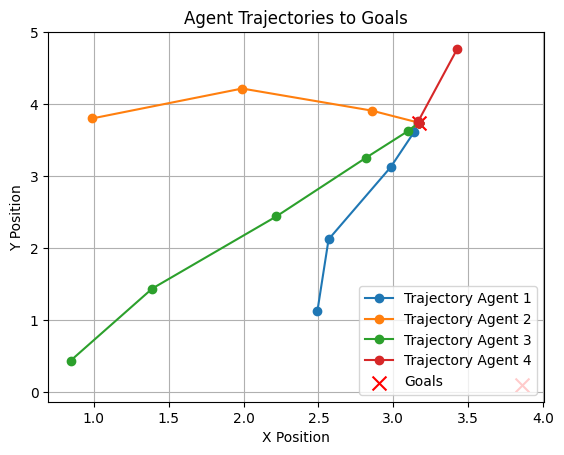

In [15]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time
np.random.seed(10)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    if x.ndim == 1:
        x = x.reshape(1, -1) # Convert 1D array to 2D array
    e_x = np.exp(x)
    return e_x / (np.sum(e_x, axis=1, keepdims=True) + 1e-16) # Add small value to avoid division by zero

# Define system dynamics
def system_dynamics(x, u, dt=1):
    return x + u * dt

# Define observation model
def observation_model(x):
    return x

def custom_cdist(x, goals, types):
    """
    Compute the pairwise distance between rows of x1 and rows of x2 based on measurement types.

    Args:
        x (np.ndarray): An array of shape (m, d)
        goals (np.ndarray): An array of shape (n, d)
        types (list): A list of measurement types for each pair of rows.
    Returns:
        np.ndarray: An array of shape (m, n) with the pairwise evidences.
    """
    assert len(types) == x.shape[0], "Length of types must match number of rows in x"

    # TODO: Implement the custom distance function
    # Compute the pairwise differences for now
    diff_to_goals = x[:, np.newaxis, :] - goals[np.newaxis, :, :]
    # Compute the pairwise distances to goals
    distances_to_goals = np.linalg.norm(diff_to_goals, axis=2)

    # Compute the pairwise differences for angles
    angles_to_goal = np.arctan2(diff_to_goals[:, :, 1], diff_to_goals[:, :, 0])
    diff_to_robot = x[:, np.newaxis, :] - x[np.newaxis, :, :]
    angles_to_robot = np.arctan2(diff_to_robot[:, :, 1], diff_to_robot[:, :, 0])
    relative_angles = np.abs((angles_to_goal - angles_to_robot + np.pi) % (2 * np.pi) - np.pi)
    # Using cosine to value alignment, where 1 means perfectly aligned and -1 means opposite
    alignment = np.cos(relative_angles)

    # Return the evidence based on the types
    # evidence = np.zeros((x1.shape[0], x2.shape[0]), dtype=np.float64)
    # goal_vectors = x2 - x1[agent_id, :]
    # goal_azimuths = np.arctan2(goal_vectors[:, 1], goal_vectors[:, 0])
    
    # for i, t in enumerate(types):
    #     if t in ['s','A']:  # Self-observation
    #         value = np.exp(-np.linalg.norm(x1[i] - x2, axis=-1) / max_distance)
    #     elif t == 'B':
    #         observed_azimuth = np.arctan2(x1[i, 1] - x1[agent_id, 1], x1[i, 0] - x1[agent_id, 0])
    #         relative_azimuths = np.abs((goal_azimuths - observed_azimuth + np.pi) % (2 * np.pi) - np.pi)
    #         # Using cosine to value alignment, where 1 means perfectly aligned and -1 means opposite
    #         alignment = np.cos(relative_azimuths)
    #         value = alignment  # Exponential scaling for smoother transition
    #     else:
    #         value = np.zeros(x2.shape[0], dtype=np.float64) + 1.0 / x2.shape[0]
        
    #     evidence[i] = value
    return distances_to_goals

def calculate_joint_goal_probs(agent_id, agent_poses, goals, predict_types, reward_configs, max_distance=30.0):
    """
    Calculate the joint goal probabilities for any number of agents and goals,
    applying a reward to specified configurations.

    Parameters:
    - agent_poses (np.ndarray): Array of shape [num_agents, 2] representing the positions of agents.
    - goals (np.ndarray): Array of shape [num_goals, 2] representing the positions of goals.
    - predict_types (list): List of types for prediction
    - reward_configs (list of tuples): List of configurations to reward. Each configuration is a tuple of goal indices.
    
    Returns:
    - joint_probabilities (np.ndarray): Array representing the joint probabilities.
    """
    num_agents = agent_poses.shape[0]
    num_goals = goals.shape[0]

    # Calculate distances between agents and goals
    evidence = custom_cdist(agent_id, agent_poses, goals, predict_types, max_distance)

    # Convert distances to probabilities using softmax
    probabilities = softmax(evidence) # Apply softmax along the goal dimension

    # Initialize joint probabilities as an array of ones with the appropriate shape
    joint_probabilities = np.ones([num_goals] * num_agents, dtype=float)

    # Calculate joint probabilities
    for i in range(num_agents):
        joint_probabilities *= probabilities[i].reshape([num_goals if j == i else 1 for j in range(num_agents)]) 

    # Only return the specified configurations
    likelihood = np.array([joint_probabilities[tuple(config)] for config in reward_configs], dtype=np.float64)

    # Normalize the joint probabilities
    likelihood = softmax(likelihood)

    return likelihood

def compute_distance(x, goals):
    # Compute the pairwise differences
    diff = x[:, np.newaxis, :] - goals[np.newaxis, :, :]
    # Compute the pairwise distances
    distances = np.linalg.norm(diff, axis=2)
    return distances

def compute_evidence(x, goals, eta=10):
    evidence = compute_distance(x, goals)
    return eta * np.exp(-1.0 / eta * evidence)

def compute_entropy(evidence, prior):
    sum_evidence = np.sum(evidence, axis=0)
    likelihood = np.exp(-sum_evidence) / np.sum(np.exp(-sum_evidence))
    posterior = likelihood * prior
    total_cost = -np.dot(posterior.T, np.log(posterior))
    return total_cost

def compute_cost(x, goals, prior):
    evidence = calculate_joint_goal_probs(x, goals)
    return compute_entropy(evidence, prior) * 1e1

# Define the optimization objective function for two agents
def objective(u, x_init, goals, N, prior, dt=1, lambda_reg=0.01):
    total_free_energy = 0
    u = u.reshape(num_agents, N, 2)  # Reshape for two agents
    x_curr = x_init.copy()
    
    for k in range(N):
        u_curr = u[:, k]
        
        # Update positions for both agents
        x_next = system_dynamics(x_curr, u_curr, dt)
        
        # Calculate total free energy considering the evidence for each other
        total_free_energy += compute_cost(x_next, goals, prior)  # Agent 1 considering Agent 2's goal
        total_free_energy += lambda_reg * (np.sum(u_curr ** 2))  # Regularization
        total_free_energy += lambda_reg * np.sum(np.min(compute_distance(x_next, goals), axis=1))
        
        # Update current positions
        x_curr = x_next
    
    return total_free_energy

# Simulation parameters
env_size = 5  # Environment size
N = int(env_size)  # Horizon length
dt = 1  # Time step
lambda_reg = 0.01  # Regularization parameter
num_goals = 2  # Number of goals
num_agents = 4  # Number of agents
goals = np.random.rand(num_goals, 2) * env_size  # Goal positions for both agents
# goals = np.array([[5.0, 5.0], [0, 5.0]])  # Goal position
x_init = np.random.rand(num_agents, 2) * env_size  # Initial positions for both agents
# x_init = np.array([[0.0, 0.0], [1.0, 0.0]])  # Initial position
u_init = np.random.rand(num_agents, N, 2)  # Initial control sequences for both agents (velocities)
prior = np.ones(num_goals) / num_goals  # Prior belief over goals
reward_configs = [tuple(np.repeat(i, num_agents)) for i in range(num_goals)]
measurement_types = ['s', 's', 's', 's']  # Self-observation for all agents

# Define constraints for control inputs
u_bounds = [(-1, 1), (-1, 1)] * N * num_agents

# Optimize the control sequence and time
start_time = time.time()
result = minimize(objective, u_init.flatten(), args=(x_init, goals, N, prior, dt, lambda_reg, reward_configs, measurement_types), 
                  bounds=u_bounds, method='L-BFGS-B', options={'maxiter': 100})
end_time = time.time()
print("Optimization time:", end_time - start_time)
# Extract the optimal control sequence
optimal_u = result.x.reshape(num_agents, N, 2)

# Simulate the system with the optimal control sequence and compute the cost
x = x_init.copy()
total_cost = 0
trajectories = [x.copy()]
for k in range(N):
    for i in range(num_agents):
        u_agent = optimal_u[i, k]
        x[i] = system_dynamics(x[i], u_agent, dt)

    total_cost += compute_cost(x, goals, prior)  # Add free energy cost
    total_cost += lambda_reg * (np.sum(optimal_u[:, k] ** 2))  # Add regularization cost
    total_cost += lambda_reg * np.sum(np.min(compute_distance(x, goals), axis=1))  # Add distance cost
    
    trajectories.append(x.copy())

trajectories = np.array(trajectories)

# Print the resulting trajectories and total cost
for i in range(num_agents):
    print(f"Optimal Control Sequence (Agent {i+1}):")
    print(optimal_u[i])
print("Resulting Trajectories:")
print(trajectories)
print("Total Cost of Optimal Trajectory:", total_cost)

# Plotting the trajectories
for i in range(num_agents):
    plt.plot(trajectories[:, i, 0], trajectories[:, i, 1], marker='o', label=f'Trajectory Agent {i+1}')
plt.scatter(goals[:, 0], goals[:, 1], marker='x', color='red', label='Goals', s=100)
plt.title('Agent Trajectories to Goals')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid()
plt.show()


### How to change what is above to a RL agent? MADDPG

In [1]:
import torch
print("Is CUDA available: ", torch.cuda.is_available())
print("CUDA device count: ", torch.cuda.device_count())

Is CUDA available:  True
CUDA device count:  1


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import gym, os
from gym import spaces
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    if x.ndim == 1:
        x = x.reshape(1, -1) # Convert 1D array to 2D array
    e_x = np.exp(x)
    return e_x / (np.sum(e_x, axis=1, keepdims=True) + 1e-16) # Add small value to avoid division by zero

class MyMultiAgentEnv(MultiAgentEnv):
    def __init__(self, config):
        self.num_agents = 3
        self.env_size = 6
        self.num_goals = 2
        self.goals = np.random.rand(self.num_goals, 2) * self.env_size
        self.state_size = self.num_agents * 2
        self.action_size = 2
        self.lambda_reg = 0.1
        self.prior = np.zeros(self.num_goals) + 1.0 / self.num_goals
        self.convergence_reward = 100  # Large reward for convergence

        # Define observation and action spaces
        self.observation_space = spaces.Box(low=0, high=self.env_size, shape=(self.state_size,), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_size,), dtype=np.float32)

        # Initialize agent IDs
        self.agent_ids = {f"agent_{i}" for i in range(self.num_agents)}

        self.reset()

    def reset(self):
        self.positions = np.random.rand(self.num_agents, 2) * self.env_size
        self.timesteps = 0
        self.prior = np.zeros(self.num_goals) + 1.0 / self.num_goals
        return {f"agent_{i}": self.positions.flatten().astype(np.float32) for i in range(self.num_agents)}

    def step(self, action_dict):
        actions = np.array([action_dict[f"agent_{i}"] for i in range(self.num_agents)])
        self.positions = np.clip(self.positions + actions, 0, self.env_size)
        self.timesteps += 1

        movement_cost = self.lambda_reg * np.linalg.norm(actions, axis=1)  # Cost for movement
        free_energy_cost = self._compute_cost()  # Free energy cost
        total_cost = free_energy_cost + movement_cost  # Total cost

        rewards = -total_cost  # Negative of total cost to minimize it
        if self._check_convergence():
            rewards += self.convergence_reward  # Add convergence reward

        done = self.timesteps >= 20 or self._check_convergence()
        obs = {f"agent_{i}": self.positions.flatten().astype(np.float32) for i in range(self.num_agents)}
        rewards = {f"agent_{i}": rewards[i] for i in range(self.num_agents)}
        dones = {f"agent_{i}": done for i in range(self.num_agents)}
        dones["__all__"] = done

        # # Debugging logs
        # print(f"Timestep {self.timesteps}:")
        # for i in range(self.num_agents):
        #     print(f"Agent {i} - Position: {self.positions[i]}, Goals: {self.goals}, Reward: {rewards[f'agent_{i}']}")

        return obs, rewards, dones, {}

    def _compute_distance(self):
        # Compute the pairwise differences
        diff = self.positions[:, np.newaxis, :] - self.goals[np.newaxis, :, :]
        
        # Compute the pairwise distances
        distances = np.linalg.norm(diff, axis=2)
        return distances

    def _compute_evidence(self, eta=10):
        evidence = self._compute_distance()
        return eta * np.exp(-1.0 / eta * evidence)

    def _compute_entropy(self, evidence):
        sum_evidence = np.sum(evidence, axis=0)
        likelihood = np.exp(-sum_evidence) / np.sum(np.exp(-sum_evidence))
        posterior = softmax(likelihood * self.prior)
        total_cost = -np.dot(posterior, np.log(posterior.T + 1e-16)).reshape(1)
        self.prior = posterior
        return total_cost

    def _compute_cost(self):
        evidence = self._compute_evidence()
        return self._compute_entropy(evidence) * 1e1

    def _check_convergence(self, threshold=0.1):
        distances_to_goals = np.min(self._compute_distance(), axis=1)
        return np.all(distances_to_goals < threshold)

    def get_agent_ids(self):
        return self.agent_ids

# Configuration for RLlib
config = {
    "env": MyMultiAgentEnv,
    "env_config": {},
    "multiagent": {
        "policies": {
            f"agent_{i}": (None, spaces.Box(low=0, high=6, shape=(6,), dtype=np.float32), spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32), {}) for i in range(3)
        },
        "policy_mapping_fn": lambda agent_id: f"agent_{int(agent_id[-1])}"
    },
    "framework": "torch",
    "num_gpus": 0,  # Number of GPUs to use
    "num_workers": 1,
    # "num_gpus_per_worker": 0.5,  # Number of GPUs to use per worker if applicable
}

# Create the checkpoint directory
checkpoint_dir = "ppo_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Train the multi-agent policy with checkpointing
trainer = PPOTrainer(config=config)
for i in range(100):
    result = trainer.train()
    print(f"Iteration {i}: mean reward = {result['episode_reward_mean']}")
    if (i + 1) % 10 == 0:  # Save checkpoint every 10 iterations
        checkpoint_path = trainer.save(checkpoint_dir)
        print(f"Checkpoint saved at {checkpoint_path}")




In [50]:
# Evaluate the trained policy
env = MyMultiAgentEnv({})
obs = env.reset()
trajectories = [env.positions.copy()]
all_reward = 0
for _ in range(50):
    actions = {f"agent_{i}": trainer.compute_single_action(obs[f"agent_{i}"], policy_id=f"agent_{i}") for i in range(3)}
    obs, rewards, done, _ = env.step(actions)
    trajectories.append(env.positions.copy())
    all_reward += sum(rewards.values())
    if done["__all__"]:
        break

trajectories = np.array(trajectories)
print(all_reward)
# Plot the resulting trajectories
for i in range(env.num_agents):
    plt.plot(trajectories[:, i, 0], trajectories[:, i, 1], marker='o', label=f'Trajectory Agent {i+1}')
plt.scatter(env.goals[:, 0], env.goals[:, 1], marker='x', color='red', label='Goals', s=100)
plt.title('Agent Trajectories to Goals')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid()
plt.show()

ValueError: shapes (1,2) and (1,2) not aligned: 2 (dim 1) != 1 (dim 0)